In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

## Load Data

In [3]:
with open('train/train.json') as f:
    train = json.load(f)
    train = pd.DataFrame(train)
with open('test1/test1.json') as f:
    test = json.load(f)
    test = pd.DataFrame(test)
train

,id,instruction,input,output,image
0,213e438b17282904772446704d0b28,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[213e438b17282904772446704d0b28-0.jpg]
1,2104a80d17282572952783243d0afd,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[2104a80d17282572952783243d0afd-0.jpg]
2,212c8bd517276234453407314d1039,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品规格,[212c8bd517276234453407314d1039-0.jpg]
3,2166278d17280312481914032d1034,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[2166278d17280312481914032d1034-0.jpg]
4,21082e0317274845152512370d0a96,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,控制方式,[21082e0317274845152512370d0a96-0.jpg]
...,...,...,...,...,...
995,d39621fd-6caf-42d8-9792-2273ec991a9e-325,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[d39621fd-6caf-42d8-9792-2273ec991a9e-325-0.jpg]
996,653c94a7-8e13-4e08-868e-91fb803e9232-627,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,支付页面,[653c94a7-8e13-4e08-868e-91fb803e9232-627-0.jpg]
997,74106cd8-d76b-459c-84c2-63b90742cde0-1088,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,物流页面-物流异常页面,[74106cd8-d76b-459c-84c2-63b90742cde0-1088-0.jpg]
998,91bea155-59a4-4926-b47c-a37e21f4b9f1-2326,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,其他类别图片,[91bea155-59a4-4926-b47c-a37e21f4b9f1-2326-0.jpg]


In [4]:
# 根据 instruction 的前 20 个字符进行分组, 分为 image 和 text两类
train['task'] = train['instruction'].str[:20].apply(
    lambda x: 'image' if x == "Picture 1: <image>\n你" else 'text'
)
train['task'].value_counts()

task
image    700
text     300
Name: count, dtype: int64

In [5]:
def save_json(df, filepath):
    formatted_data = [
        {
            "id": row["id"],
            "instruction": row["instruction"],
            "input": row["input"],
            "output": row["output"],
            "image": row["image"] if isinstance(row["image"], list) else [row["image"]],
        }
        for _, row in df.iterrows()
    ]
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(formatted_data, f, ensure_ascii=False, indent=4)


In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 读取 train 数据，假设 train 是一个 DataFrame
train_image = train[train['task'] == 'image'].copy()
train_text = train[train['task'] == 'text'].copy()

# 对 train_image 数据集进行分层抽样
train_image, valid_image = train_test_split(
    train_image, test_size=0.2, random_state=42, stratify=train_image['output']
)
train_image.reset_index(drop=True, inplace=True)
valid_image.reset_index(drop=True, inplace=True)

# 保存分层抽样后的 train_image 和 valid_image
save_json(train_image, "train/train_image.json")
save_json(valid_image, "train/valid_image.json")

# 对 train_text 数据集进行分层抽样
train_text, valid_text = train_test_split(
    train_text, test_size=0.2, random_state=42, stratify=train_text['output']
)
train_text.reset_index(drop=True, inplace=True)
valid_text.reset_index(drop=True, inplace=True)

# 保存分层抽样后的 train_text 和 valid_text
save_json(train_text, "train/train_text.json")
save_json(valid_text, "train/valid_text.json")


## Data Exploration

### Length of two kinds of `instruction` 

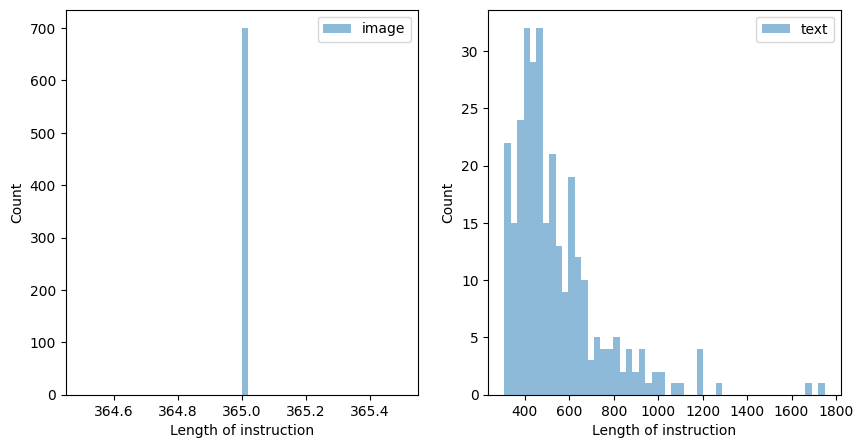

In [22]:
# 计算 image 和 text 类型的 instruction 的长度,并绘制两个子图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_image['instruction'].str.len(), bins=50, alpha=0.5, label='image')
plt.xlabel('Length of instruction')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(train_text['instruction'].str.len(), bins=50, alpha=0.5, label='text')
plt.xlabel('Length of instruction')
plt.ylabel('Count')
plt.legend()
plt.show()

In [23]:
# 将 instruction长度超过 1000 的instruction打印出来看看
train[train['instruction'].str.len() > 1000]

,id,instruction,input,output,image,task
5,2107347617277435206931576d0af4,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否易褪色,[2107347617277435206931576d0af4-0.jpg],text
49,213dbbe517278865952913592d0b10,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否好用,[213dbbe517278865952913592d0b10-0.jpg],text
111,212c5b2e17276183422897200d0b24,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[212c5b2e17276183422897200d0b24-0.jpg],text
179,212ccb5917282965269817932d13fb,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[212ccb5917282965269817932d13fb-0.jpg],text
213,0bf8fbfd17277183295445449d0ad8,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,用法用量,[0bf8fbfd17277183295445449d0ad8-0.jpg],text
239,0b52090217282960000927920d0b32,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,套装推荐,"[0b52090217282960000927920d0b32-0.jpg, 0b52090...",text
267,213ca3f617272237777542707d101d,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[213ca3f617272237777542707d101d-0.jpg],text
278,213ef6a617273607777854871d0b7c,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,套装推荐,[213ef6a617273607777854871d0b7c-0.jpg],text
282,213e5b6717280386556962296d1006,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,能否调光,"[213e5b6717280386556962296d1006-0.jpg, 213e5b6...",text
285,2107bb1017279214296645020d0f68,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,养护方法,[2107bb1017279214296645020d0f68-0.jpg],text


In [24]:
def extract_messages(instruction):
    # Regular expressions to extract user and customer messages
    user_pattern = r"用户: (.+)"
    customer_pattern = r"客服: (.+)"
    
    # Extracting the messages
    user_messages = re.findall(user_pattern, instruction)
    customer_messages = re.findall(customer_pattern, instruction)
    return user_messages, customer_messages

train_text['user_messages'], train_text['customer_messages'] = zip(*train_text['instruction'].apply(extract_messages))
train_text

,id,instruction,input,output,image,task,user_messages,customer_messages
0,213e438b17282904772446704d0b28,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[213e438b17282904772446704d0b28-0.jpg],text,"[<image>, <http>, 内胆使用的是316不锈钢吗]","[抱歉哦，小富目前还不能识别图片，您可以简单描述一下遇到的问题吗？/:068~~, 若您仍有..."
1,2104a80d17282572952783243d0afd,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[2104a80d17282572952783243d0afd-0.jpg],text,"[<http>, <image>, 亲爱的:这款商品是全部采用金属材质的吗？]","[您具体想要了解什么问题呢？, 亲爱的顾客，我们的智能助手还在成长中，目前还无法识别图片内容..."
2,212c8bd517276234453407314d1039,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品规格,[212c8bd517276234453407314d1039-0.jpg],text,"[<http>, <image>, 这是指两件商品吗？]",[国庆促销狂欢 【护肤隔离霜】 ⏰促销时间：9月26日20:00~10月7日23:59 ...
3,2166278d17280312481914032d1034,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[2166278d17280312481914032d1034-0.jpg],text,"[<http>, 这是关于上方排水的问题, <image>, 这是指顶部排水还是底部排水？]",[重磅消息【大家期待已久的市政府补贴活动来了】!! 【以旧换新 市政府补贴】特定型号的一级能...
4,21082e0317274845152512370d0a96,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,控制方式,[21082e0317274845152512370d0a96-0.jpg],text,"[<http>, 智能控制, ""代码A1"", 起居室照明, 这个也能用控制盒操作吧, <im...","[亲爱的，我们已经查看了您提供的商品链接，欢迎分享您的问题，我们将全力以赴帮助您解决/:Q,..."
...,...,...,...,...,...,...,...,...
295,0b1fecf117281996029976346d1433,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,反馈密封性不好,[0b1fecf117281996029976346d1433-0.jpg],text,"[""<http>"", <image>, {""height"":1280,""duration"":...",[重磅消息【大家期待已久的市政府补贴活动来了】!! 【以旧换新 市政府补贴】特定型号的一级能...
296,216715cd17278240446705339d103e,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,单品推荐,[216715cd17278240446705339d103e-0.jpg],text,"[<image>, 有没有一样的？]",[您好！这款商品您遇到了什么问题吗？]
297,210475c617280231013845576d0fca,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,发货数量,[210475c617280231013845576d0fca-0.jpg],text,"[""<http>"", 客服, <image>, 该款式的网络链接, 发送一条]",[Apple Watch Ultra 2 配备了49毫米的航空级钛金属表壳，操控上采用了具备...
298,213e87c017273184139862170d0fd5,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,套装推荐,[213e87c017273184139862170d0fd5-0.jpg],text,"[<image>, 这组链接]","[抱歉，客户，我们暂时无法识别图片内容，麻烦您用文字详细说明一下遇到的问题吗？, 亲爱的，商..."


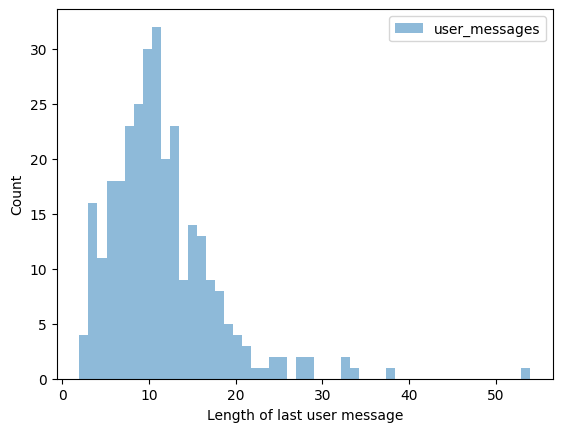

In [25]:
# 统计 user_messages的最后一个元素的长度，并绘制直方图
plt.hist([len(x[-1]) for x in train_text['user_messages']], bins=50, alpha=0.5, label='user_messages')
plt.xlabel('Length of last user message')
plt.ylabel('Count')
plt.legend()
plt.show()

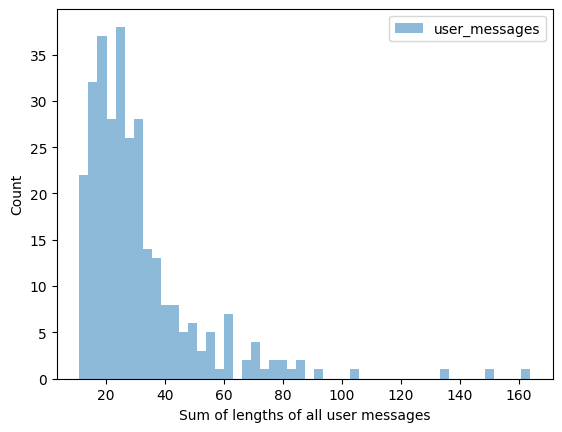

In [26]:
# 统计 user_messages的所有元素的长度和，并绘制直方图
plt.hist([sum(len(x) for x in y) for y in train_text['user_messages']], bins=50, alpha=0.5, label='user_messages')
plt.xlabel('Sum of lengths of all user messages')
plt.ylabel('Count')
plt.legend()
plt.show()

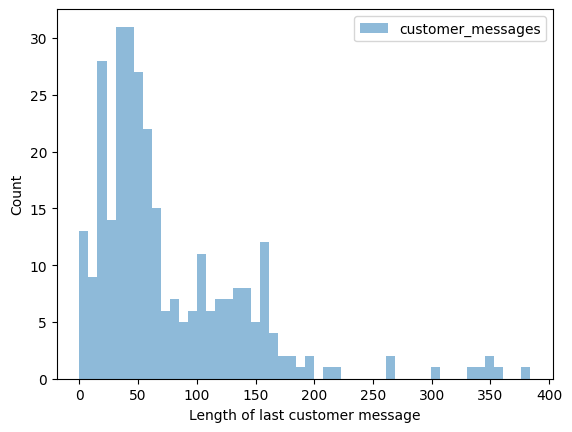

In [27]:
# 统计 customer_messages的最后一个元素的长度，并绘制直方图
plt.hist([len(x[-1]) if len(x)>0 else 0 for x in train_text['customer_messages']], bins=50, alpha=0.5, label='customer_messages')
plt.xlabel('Length of last customer message')
plt.ylabel('Count')
plt.legend()
plt.show()

## labels distribution

In [7]:
train_text['output'].value_counts()

output
适用季节       19
单品推荐       16
包装区别       14
套装推荐       14
用法用量       14
版本款型区别     14
功效功能       14
反馈密封性不好    12
能否调光       11
商品材质       11
发货数量       11
商品规格       11
控制方式       10
气泡         10
何时上货       10
上市时间        9
养护方法        8
信号情况        7
排水方式        7
是否会生锈       6
是否好用        6
是否易褪色       3
反馈用后症状      3
Name: count, dtype: int64

In [8]:
train_image['output'].value_counts()

output
商品分类选项                 31
商品详情页截图                30
优惠券领取页面                30
购物车页面                  30
活动页面                   30
商品头图                   30
支付页面                   30
退货页面                   30
账单/账户页面                29
退款页面                   29
其他类别图片                 28
投诉举报页面                 25
外部APP截图                25
店铺页面                   24
下单过程中出现异常（显示购买失败浮窗）    22
评论区截图页面                22
物流页面-物流跟踪页面            21
物流页面-物流异常页面            20
换货页面                   18
实物拍摄(含售后)              18
平台介入页面                 14
订单详情页面                 12
物流页面-物流列表页面            12
Name: count, dtype: int64

In [30]:
train_image

,id,instruction,input,output,image,task
300,3fc85b30-3ab3-4cad-a2de-324e2ae6a078-1279,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,退货页面,[3fc85b30-3ab3-4cad-a2de-324e2ae6a078-1279-0.jpg],image
301,19c1964c-5f1b-41b3-98fe-405a987e9358-8,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,实物拍摄(含售后),[19c1964c-5f1b-41b3-98fe-405a987e9358-8-0.jpg],image
302,6f59b27a-2321-45aa-b0f3-b245d19d1883-1591,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,店铺页面,[6f59b27a-2321-45aa-b0f3-b245d19d1883-1591-0.jpg],image
303,e7a3565c-a077-4497-8b23-707ae7d16236-1517,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,店铺页面,[e7a3565c-a077-4497-8b23-707ae7d16236-1517-0.jpg],image
304,fac5b276-8b3f-48c3-af74-3d83b2a1535f-621,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,支付页面,[fac5b276-8b3f-48c3-af74-3d83b2a1535f-621-0.jpg],image
...,...,...,...,...,...,...
995,d39621fd-6caf-42d8-9792-2273ec991a9e-325,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[d39621fd-6caf-42d8-9792-2273ec991a9e-325-0.jpg],image
996,653c94a7-8e13-4e08-868e-91fb803e9232-627,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,支付页面,[653c94a7-8e13-4e08-868e-91fb803e9232-627-0.jpg],image
997,74106cd8-d76b-459c-84c2-63b90742cde0-1088,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,物流页面-物流异常页面,[74106cd8-d76b-459c-84c2-63b90742cde0-1088-0.jpg],image
998,91bea155-59a4-4926-b47c-a37e21f4b9f1-2326,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,其他类别图片,[91bea155-59a4-4926-b47c-a37e21f4b9f1-2326-0.jpg],image


## 不同 input 设计需要的长度

In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./Qwen2.5-1.5B")

In [31]:
def design_input_text(user_messages, customer_messages, save='user+'):
    input_text = ''
    if save == 'user+':
        input_text = '用户: ' + ' '.join(user_messages)
    elif save == 'user+customer-':
        if len(customer_messages) > 0:
            input_text = '用户: ' + ' '.join(user_messages) + ' ' + '客服: ' + customer_messages[-1]
        else:
            input_text = '用户: ' + ' '.join(user_messages) + ' ' + '客服: ' + '无'
    elif save == 'user-':
        input_text = '用户: ' + user_messages[-1]
    elif save == 'user-customer-':
        if len(customer_messages) > 0:
            input_text = '用户: ' + user_messages[-1] + ' ' + '客服: ' + customer_messages[-1]
        else:
            input_text = '用户: ' + user_messages[-1] + ' ' + '客服: ' + '无'

    return input_text

In [33]:
for mode in ['user+', 'user+customer-', 'user-', 'user-customer-']:
    train_text[mode] = train_text.apply(lambda row: design_input_text(row['user_messages'], row['customer_messages'], save=mode), axis=1)
    train_text[mode+'_ids'] = train_text[mode].apply(lambda x: tokenizer.encode(x))
train_text

,id,instruction,input,output,image,task,user_messages,customer_messages,user+,user+_ids,user+customer-,user+customer-_ids,user-,user-_ids,user-customer-,user-customer-_ids
0,213e438b17282904772446704d0b28,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[213e438b17282904772446704d0b28-0.jpg],text,"[<image>, <http>, 内胆使用的是316不锈钢吗]","[抱歉哦，小富目前还不能识别图片，您可以简单描述一下遇到的问题吗？/:068~~, 若您仍有...",用户: <image> <http> 内胆使用的是316不锈钢吗,"[20002, 25, 366, 1805, 29, 366, 1254, 29, 6873...",用户: <image> <http> 内胆使用的是316不锈钢吗 客服: 亲爱的，升级版的抗...,"[20002, 25, 366, 1805, 29, 366, 1254, 29, 6873...",用户: 内胆使用的是316不锈钢吗,"[20002, 25, 68739, 227, 101335, 37029, 100146,...",用户: 内胆使用的是316不锈钢吗 客服: 亲爱的，升级版的抗菌不锈钢是在304不锈钢的基础...,"[20002, 25, 68739, 227, 101335, 37029, 100146,..."
1,2104a80d17282572952783243d0afd,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[2104a80d17282572952783243d0afd-0.jpg],text,"[<http>, <image>, 亲爱的:这款商品是全部采用金属材质的吗？]","[您具体想要了解什么问题呢？, 亲爱的顾客，我们的智能助手还在成长中，目前还无法识别图片内容...",用户: <http> <image> 亲爱的:这款商品是全部采用金属材质的吗？,"[20002, 25, 366, 1254, 29, 366, 1805, 29, 220,...",用户: <http> <image> 亲爱的:这款商品是全部采用金属材质的吗？ 客服: 亲爱...,"[20002, 25, 366, 1254, 29, 366, 1805, 29, 220,...",用户: 亲爱的:这款商品是全部采用金属材质的吗？,"[20002, 25, 220, 110834, 25, 101469, 45943, 20...",用户: 亲爱的:这款商品是全部采用金属材质的吗？ 客服: 亲爱的顾客，我们的智能助手还在成长...,"[20002, 25, 220, 110834, 25, 101469, 45943, 20..."
2,212c8bd517276234453407314d1039,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品规格,[212c8bd517276234453407314d1039-0.jpg],text,"[<http>, <image>, 这是指两件商品吗？]",[国庆促销狂欢 【护肤隔离霜】 ⏰促销时间：9月26日20:00~10月7日23:59 ...,用户: <http> <image> 这是指两件商品吗？,"[20002, 25, 366, 1254, 29, 366, 1805, 29, 3218...",用户: <http> <image> 这是指两件商品吗？ 客服: 亲爱的，这款隔离霜是单个包...,"[20002, 25, 366, 1254, 29, 366, 1805, 29, 3218...",用户: 这是指两件商品吗？,"[20002, 25, 32181, 247, 104442, 77540, 14224, ...",用户: 这是指两件商品吗？ 客服: 亲爱的，这款隔离霜是单个包装的，每个完整的隔离霜重量为3...,"[20002, 25, 32181, 247, 104442, 77540, 14224, ..."
3,2166278d17280312481914032d1034,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[2166278d17280312481914032d1034-0.jpg],text,"[<http>, 这是关于上方排水的问题, <image>, 这是指顶部排水还是底部排水？]",[重磅消息【大家期待已久的市政府补贴活动来了】!! 【以旧换新 市政府补贴】特定型号的一级能...,用户: <http> 这是关于上方排水的问题 <image> 这是指顶部排水还是底部排水？,"[20002, 25, 366, 1254, 29, 32181, 247, 20412, ...",用户: <http> 这是关于上方排水的问题 <image> 这是指顶部排水还是底部排水？ ...,"[20002, 25, 366, 1254, 29, 32181, 247, 20412, ...",用户: 这是指顶部排水还是底部排水？,"[20002, 25, 32181, 247, 104442, 111446, 107266...",用户: 这是指顶部排水还是底部排水？ 客服: 亲爱的顾客，关于波轮式洗衣机：它们都采用下排水...,"[20002, 25, 32181, 247, 104442, 111446, 107266..."
4,21082e0317274845152512370d0a96,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,控制方式,[21082e0317274845152512370d0a96-0.jpg],text,"[<http>, 智能控制, ""代码A1"", 起居室照明, 这个也能用控制盒操作吧, <im...","[亲爱的，我们已经查看了您提供的商品链接，欢迎分享您的问题，我们将全力以赴帮助您解决/:Q,...","用户: <http> 智能控制 ""代码A1"" 起居室照明 这个也能用控制盒操作吧 <imag...","[20002, 25, 366, 1254, 29, 6567, 247, 118, 262...","用户: <http> 智能控制 ""代码A1"" 起居室照明 这个也能用控制盒操作吧 <imag...","[20002, 25, 366, 1254, 29, 6567, 247, 118, 262...",用户: 这一个,"[20002, 25, 32181, 247, 46944]",用户: 这一个 客服: 亲爱的，挑选相关商品时，请注意商品详情页中的图片说明，显示该商品配备...,"[20002, 25, 32181, 247, 46944, 41479, 95, 4320..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0b1fecf117281996029976346d1433,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,反馈密封性不好,[0b1fecf117281996029976346d1433-0.jpg],text,"[""<http>"", <image>, {""height"":1280,""duration"":...",[重磅消息【大家期待已久的市政府补贴活动来了】!! 【以旧换新 市政府补贴】特定型号的一级能...,"用户: ""<http>"" <image> {""height"":1280,""duration""...","[20002, 25, 4055, 1254, 9877, 366, 1805, 29, 5...","用户: ""<http>"" <image> {""height"":1280,""duration""...","[20002, 25, 4055, 1254, 9877, 366, 1805, 29, 5...",用户: 水管漏水是怎么回事,"[20002, 25, 6567, 108, 112, 35551, 117624, 107...",用户: 水管漏水是怎么回事 客服: 亲爱的顾客，非常抱歉给您带来了不便。如果商品出现问题，您...,"[20002, 25, 6567, 108, 112, 35551, 117624, 107..."
296,216715cd17278240446705339d103e,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,单品推荐,[216715cd17278240446705339d103e-0.jpg],text,"[<image>, 有没有一样的？]",[您好！这款商品您遇到了什么问题吗？],用户: <imag

In [34]:
# 统计不同 mode 下的长度
train_text[['user+', 'user+customer-', 'user-', 'user-customer-']].apply(lambda x: x.apply(lambda y: len(y)))

,user+,user+customer-,user-,user-customer-
0,32,253,17,238
1,39,96,24,81
2,28,99,13,84
3,45,215,18,188
4,52,147,7,102
...,...,...,...,...
295,157,317,13,173
296,19,41,11,33
297,37,69,8,40
298,16,69,8,61


In [39]:
input_ids_len = train_text[['user+_ids', 'user+customer-_ids', 'user-_ids', 'user-customer-_ids']].apply(lambda x: x.apply(lambda y: len(y)))
# 每列的最大值，最小值，均值，90%分位数，95%分位数
input_ids_len.apply(lambda x: [max(x), min(x), np.mean(x), np.percentile(x, 90), np.percentile(x, 95), np.percentile(x, 98)])

,user+_ids,user+customer-_ids,user-_ids,user-customer-_ids
0,135.00,322.000000,35.000000,302.000000
1,8.00,15.000000,5.000000,12.000000
2,22.84,76.666667,10.866667,64.693333
3,38.10,134.300000,15.000000,120.200000
4,50.05,170.050000,18.000000,140.050000
5,68.00,231.040000,21.020000,215.200000


In [40]:
input_ids_len

,user+_ids,user+customer-_ids,user-_ids,user-customer-_ids
0,18,161,12,155
1,21,56,15,50
2,16,66,10,60
3,24,125,11,112
4,35,96,5,66
...,...,...,...,...
295,79,172,9,102
296,9,25,6,22
297,20,43,5,28
298,9,40,6,37


### create labels map

In [44]:
text_labels = train_text['output'].unique().tolist()
text_labels_map = {label: i for i, label in enumerate(text_labels)}
text_labels_map

{'商品材质': 0,
 '商品规格': 1,
 '排水方式': 2,
 '控制方式': 3,
 '是否易褪色': 4,
 '上市时间': 5,
 '是否会生锈': 6,
 '反馈用后症状': 7,
 '适用季节': 8,
 '何时上货': 9,
 '发货数量': 10,
 '功效功能': 11,
 '套装推荐': 12,
 '是否好用': 13,
 '用法用量': 14,
 '包装区别': 15,
 '能否调光': 16,
 '单品推荐': 17,
 '版本款型区别': 18,
 '反馈密封性不好': 19,
 '气泡': 20,
 '养护方法': 21,
 '信号情况': 22}

In [46]:
image_labels = train_image['output'].unique().tolist()
image_labels_map = {label: i for i, label in enumerate(image_labels)}
image_labels_map

{'退货页面': 0,
 '实物拍摄(含售后)': 1,
 '店铺页面': 2,
 '支付页面': 3,
 '优惠券领取页面': 4,
 '物流页面-物流异常页面': 5,
 '商品详情页截图': 6,
 '投诉举报页面': 7,
 '换货页面': 8,
 '商品分类选项': 9,
 '活动页面': 10,
 '商品头图': 11,
 '外部APP截图': 12,
 '物流页面-物流跟踪页面': 13,
 '购物车页面': 14,
 '退款页面': 15,
 '平台介入页面': 16,
 '其他类别图片': 17,
 '订单详情页面': 18,
 '评论区截图页面': 19,
 '账单/账户页面': 20,
 '物流页面-物流列表页面': 21,
 '下单过程中出现异常（显示购买失败浮窗）': 22}

In [9]:
len(train_text),len(valid_text)

(240, 60)